In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/Users/Work/Developer/interpretDL/Pipeline")

import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [2]:
import numpy as np
import pandas as pd
import umap
from sklearn.datasets import make_classification
from helper import split_valid, plot_confusion_matrix

np.random.seed(seed=42) 

In [11]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4], "C":[1,10]},
    { "max_iter":[10000000], "loss":["squared_hinge", "hinge"], "tol":[1e-4], "C":[1,10,30]}
]

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC(**{'C': 1, "loss":"hinge", 'max_iter': 10000000,
                        'penalty': 'l2', 'tol': 0.0001, "class_weight":"balanced"}))
])

def runSVM(X,y, X_valid,y_valid):
    
    clf_grid = Pipeline([
        ("scaler", StandardScaler()),
        ("SVMGrid",GridSearchCV(LinearSVC(), param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=8))
    ])
    
    clf_grid.fit(X, y)
    grid = clf_grid.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    svm_clf.fit(X, y)
    print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

    _score = cross_val_score(svm_clf, X=X, y=y, cv=10)
    print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    return svm_clf, grid.best_params_

In [4]:
X,y = make_classification(n_samples=10000, n_classes=3, weights=[0.5,0.25,0.25], n_features=10,
                          n_informative=5, n_redundant=5, class_sep=0.7, n_clusters_per_class=1,
                          hypercube=True, shuffle=False, random_state=42)
# X,y = make_classification(n_samples=3000, n_classes=3, n_informative=3, class_sep=1, n_clusters_per_class=1, hypercube=False, shuffle=False, random_state=42)
X.shape

(10000, 10)

In [5]:
from sklearn.utils.class_weight import compute_class_weight
compute_class_weight("balanced", np.unique(y), y)

array([0.66827052, 1.33067199, 1.32961042])

In [12]:
reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=100,
                    min_dist=1)
embedding = reducer.fit_transform(X)

# embedding=X[:, :3]

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/rp_tree.py:450: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/rp_tree.py (457)

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUD

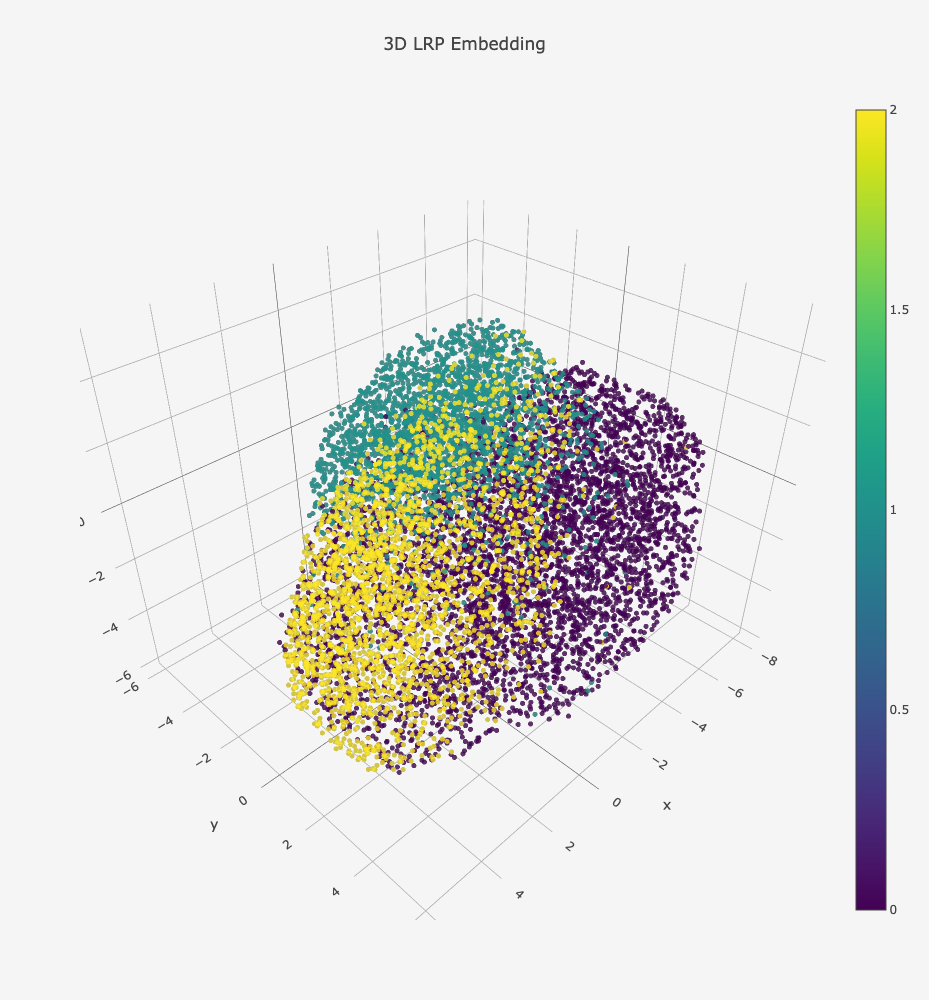

In [15]:
emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=3,
        color=y,
        colorscale="Viridis",
        showscale=True,
        opacity=0.8
    ),
    text=y
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5'
)


pltdata=[emb3d]

fig = go.Figure(data=pltdata, layout=layout)
iplot(fig, filename='lrp-3d-heart.html')

In [17]:
from helper import split_valid, plot_confusion_matrix
from sklearn.metrics import classification_report

data = pd.DataFrame(X)
labels = pd.Series(y)

X_train, y_train, X_valid, y_valid = split_valid(data, labels, valid_size=0.5)

In [18]:
y_valid.value_counts()

0    2494
2    1253
1    1253
dtype: int64

In [20]:
%time clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

CPU times: user 80.6 ms, sys: 2.09 ms, total: 82.7 ms
Wall time: 83.3 ms
SVM Test Accuracy: 0.747


In [21]:
# original_svm, orig_best_params = runSVM(X_train, y_train, X_valid, y_valid)
original_svm = clf

In [22]:
y_pred = original_svm.predict(X_valid)
target_names = np.array(["A","B","C"])
print(classification_report(y_valid.values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           A       0.82      0.83      0.83      2494
           B       0.71      0.78      0.74      1253
           C       0.63      0.54      0.58      1253

    accuracy                           0.75      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.74      0.75      0.74      5000



Confusion matrix, without normalization
[[0.83480353 0.04009623 0.12510024]
 [0.14844374 0.78132482 0.07023144]
 [0.2226656  0.23782921 0.53950519]]
Overall Accuracy: 0.7474


(<matplotlib.axes._subplots.AxesSubplot at 0x1a33e45d68>,
 array([[2082,  100,  312],
        [ 186,  979,   88],
        [ 279,  298,  676]]))

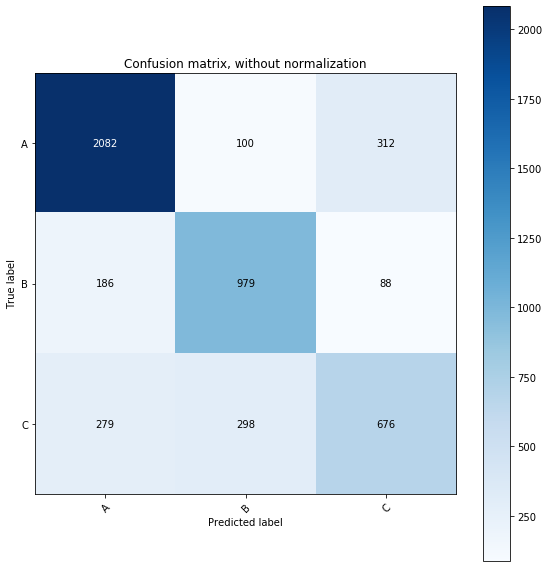

In [23]:
plot_confusion_matrix(y_valid.values, y_pred.astype(int), target_names)

In [24]:
new_data = pd.DataFrame(columns=data.columns)
new_labels = pd.Series()

skip_class = 0
# class_size = labels.value_counts()[skip_class]

# for labl in range(3):
#     _labels = labels[ labels == labl]
    
#     size = class_size #//2
# #     if labl == skip_class: size *=2 # To balance final binary classes 
    
#     rand_selected = _labels.sample(n=size, replace=False, random_state=42).index
#     _data = data.reindex(rand_selected)
#     _labels = _labels.reindex(rand_selected)
    
#     new_data = new_data.append(_data)
#     new_labels = new_labels.append(_labels)


new_data = data.copy()
new_labels = labels.copy()

new_labels[new_labels == skip_class] = -1

new_labels[new_labels != -1] = 1

# skip_class is now control
new_labels[new_labels == -1] = 0

print(new_data.shape)
new_data.head()

(10000, 10)


,0,1,2,3,4,5,6,7,8,9
0,-0.298819,-0.207636,0.336740,-0.241800,0.511053,-0.169162,0.115048,-1.010166,0.322902,0.191744
1,3.032506,2.915460,-2.028930,-3.457300,-1.082616,1.590476,-5.863924,0.670564,-2.421442,-4.603312
2,2.896556,0.639597,-1.310574,-1.355019,0.830541,-0.418640,-2.133277,-1.151617,-1.033043,-2.155477
3,-0.011948,0.154973,1.231940,-0.171779,0.768823,-1.173593,-0.750644,-1.665942,-0.131173,-0.064675
4,5.107862,-1.077666,-1.784118,-1.287695,2.608005,-1.811146,-1.072125,-3.929656,-1.482275,-2.297513


In [25]:
X_train, y_train, X_valid, y_valid = split_valid(new_data, new_labels, valid_size=0.5)
X_train.index

Int64Index([2010, 3196, 2113, 8463, 7027, 8377, 5051, 8721, 3776, 2771,
            ...
            7499, 9351, 6298, 3063, 5317, 6911, 2586, 9961, 4615, 5736],
           dtype='int64', length=5000)

In [26]:
%time clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

CPU times: user 22.1 ms, sys: 1.28 ms, total: 23.3 ms
Wall time: 22.5 ms
SVM Test Accuracy: 0.839


In [27]:
# original_svm, orig_best_params = runSVM(X_train, y_train, X_valid, y_valid)

In [28]:
original_svm = clf
y_pred = original_svm.predict(X_valid)
target_names = np.array(["A","BC"])
print(classification_report(y_valid.values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           A       0.81      0.88      0.85      2494
          BC       0.87      0.80      0.83      2506

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



Confusion matrix, without normalization
[[0.87890938 0.12109062]
 [0.20031923 0.79968077]]
Overall Accuracy: 0.8392


(<matplotlib.axes._subplots.AxesSubplot at 0x1a33a8a898>, array([[2192,  302],
        [ 502, 2004]]))

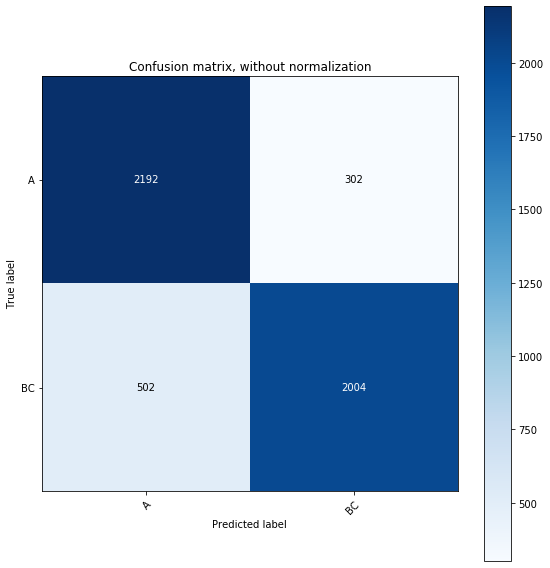

In [29]:
plot_confusion_matrix(y_valid.values, y_pred.astype(int), target_names)

# Looking at subclusters separated

In [30]:
X_train, y_train, X_valid, y_valid = split_valid(data, labels, valid_size=0.5)

In [378]:
from sklearn.utils.multiclass import unique_labels

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC(**{'C': 1, 'max_iter': 10000000, 'loss': 'hinge',
                        'tol': 0.0001, "class_weight":"balanced"}))
])


from imblearn.over_sampling import SMOTE

def runSVMAnalysis(skip_class, classes=np.array(["A","B","C"])):
    
    _X = X_train[y_train != skip_class]
    _y = y_train[y_train != skip_class]
    
#     bi_train, bi_y_train = SMOTE(random_state=42).fit_resample(_X,np.ravel(_y))

    bi_train, bi_y_train = _X, _y
    
    bi_valid = X_valid[y_valid != skip_class]
    bi_y_valid = y_valid[y_valid != skip_class]
    
    %time clf.fit(bi_train, bi_y_train)
    print("SVM Test Accuracy: {:0.3f}".format(clf.score(bi_valid, bi_y_valid)))

#     bi_svm, bi_best_params = runSVM(bi_train, bi_y_train, bi_valid, bi_y_valid)
    bi_svm = clf
    
    y_pred =  bi_svm.predict(bi_valid)
    correct_ = bi_y_valid[y_pred == bi_y_valid]

    # Only use the labels that appear in the data
    print(unique_labels(bi_y_valid, y_pred))
    target_names = classes[unique_labels(bi_y_valid, y_pred)]
    print(classification_report(bi_y_valid.values, y_pred, target_names=target_names))

    plot_confusion_matrix(bi_y_valid.values, y_pred.astype(int), classes)
    
    return correct_

## A vs B

CPU times: user 13.6 ms, sys: 377 µs, total: 14 ms
Wall time: 13.9 ms
SVM Test Accuracy: 0.930
[0 1]
              precision    recall  f1-score   support

           A       0.93      0.97      0.95      2494
           B       0.93      0.86      0.89      1253

    accuracy                           0.93      3747
   macro avg       0.93      0.91      0.92      3747
weighted avg       0.93      0.93      0.93      3747

Confusion matrix, without normalization
[[0.96511628 0.03488372]
 [0.13886672 0.86113328]]
Overall Accuracy: 0.9303


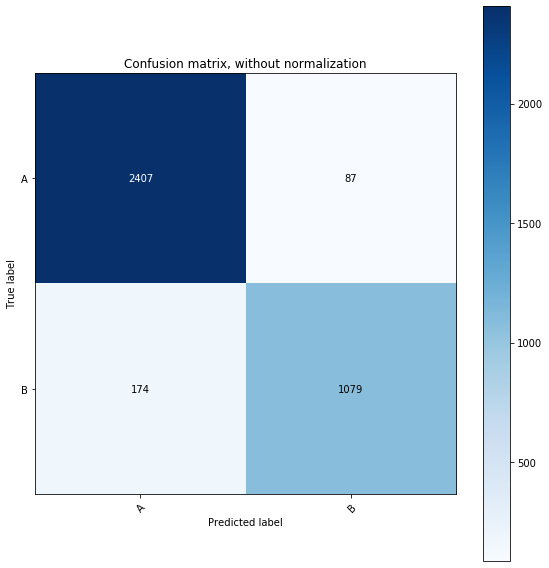

In [379]:
correct_AB = runSVMAnalysis(skip_class=2)

## A vs C

CPU times: user 22.6 ms, sys: 431 µs, total: 23 ms
Wall time: 22.8 ms
SVM Test Accuracy: 0.800
[0 2]
              precision    recall  f1-score   support

           A       0.93      0.76      0.84      2494
           C       0.65      0.88      0.75      1253

    accuracy                           0.80      3747
   macro avg       0.79      0.82      0.79      3747
weighted avg       0.83      0.80      0.81      3747

Confusion matrix, without normalization
[[0.75942261 0.24057739]
 [0.11811652 0.88188348]]
Overall Accuracy: 0.8004


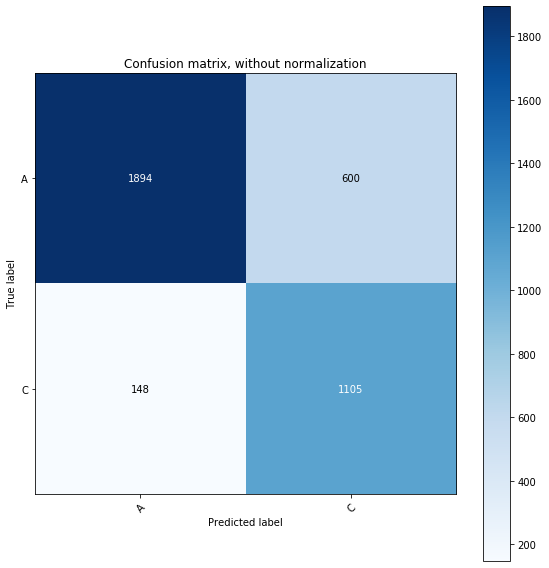

In [380]:
correct_AC = runSVMAnalysis(skip_class=1)

In [381]:
bc_recall = len(correct_AB[correct_AB == 1]) + len(correct_AC[correct_AC == 2])
print("BC Accuracy:",bc_recall)

BC Accuracy: 2184


In [382]:
y_valid.value_counts()

0    2494
2    1253
1    1253
dtype: int64

In [383]:
bc_recall/(y_valid.value_counts()[1]*2)

0.8715083798882681

In [384]:
(bc_recall-2005)/2005

0.08927680798004987

In [298]:
2184/2506

0.8715083798882681

## B vs C

CPU times: user 13.8 ms, sys: 1.34 ms, total: 15.1 ms
Wall time: 15.2 ms
SVM Test Accuracy: 0.856
[1 2]
              precision    recall  f1-score   support

           B       0.82      0.91      0.86      1253
           C       0.90      0.80      0.85      1253

    accuracy                           0.86      2506
   macro avg       0.86      0.86      0.86      2506
weighted avg       0.86      0.86      0.86      2506

Confusion matrix, without normalization
[[0.90901836 0.09098164]
 [0.1971269  0.8028731 ]]
Overall Accuracy: 0.8559


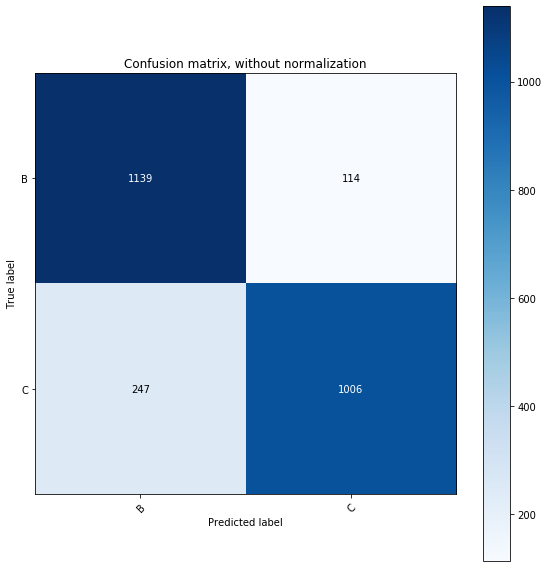

In [308]:
correct_BC = runSVMAnalysis(skip_class=0)

## Looking at final per-class accuracies

In [171]:
y_valid.value_counts()

0    2494
2    1253
1    1253
dtype: int64

In [385]:
A_idxs_1 = set(correct_AC[correct_AC == 0].index)
A_idxs_2 = set(correct_AB[correct_AB == 0].index)

A_total = A_idxs_1.intersection(A_idxs_2)
print("Number of A samples predicted:", len(A_total))
print("Ratio:", len(A_total)/y_valid.value_counts()[0])

Number of A samples predicted: 1865
Ratio: 0.7477947072975141


In [173]:
B_idxs_1 = set(correct_BC[correct_BC == 1].index)
B_idxs_2 = set(correct_AB[correct_AB == 1].index)

B_total = B_idxs_1.union(B_idxs_2)
print("Number of B samples predicted:", len(B_total))
print("Ratio:", len(B_total)/y_valid.value_counts()[1])

Number of B samples predicted: 1193
Ratio: 0.9521149241819633


In [174]:
# B_total - B_idxs_1

In [175]:
C_idxs_1 = set(correct_BC[correct_BC == 2].index)
C_idxs_2 = set(correct_AC[correct_AC == 2].index)

C_total = C_idxs_1.union(C_idxs_2)
print("Number of C samples predicted:", len(C_total))
print("Ratio:", len(C_total)/y_valid.value_counts()[2])

Number of C samples predicted: 1179
Ratio: 0.9409417398244214


In [ ]:
# y_true = svm.predict

In [176]:
# C_total - C_idxs_2

## By looking at these observations, we have evidence that the dataset will perform well for our analysis
## The initial binary classification should be A vs (B v C)
## The results above show us that A vs C and B vs C should both perform better

In [177]:
labels.value_counts().min()

2505

# Important dims

In [184]:
# data[range(5)]

In [185]:
new_data = data[range(5)].copy()
new_labels = labels.copy()

new_labels[new_labels == skip_class] = -1

new_labels[new_labels != -1] = 1

# skip_class is now control
new_labels[new_labels == -1] = 0

print(new_data.shape)
new_data.head()

(10000, 5)


,0,1,2,3,4
0,-0.298819,-0.207636,0.336740,-0.241800,0.511053
1,3.032506,2.915460,-2.028930,-3.457300,-1.082616
2,2.896556,0.639597,-1.310574,-1.355019,0.830541
3,-0.011948,0.154973,1.231940,-0.171779,0.768823
4,5.107862,-1.077666,-1.784118,-1.287695,2.608005


In [186]:
X_train, y_train, X_valid, y_valid = split_valid(new_data, new_labels, valid_size=0.5)
X_train.index

Int64Index([2010, 3196, 2113, 8463, 7027, 8377, 5051, 8721, 3776, 2771,
            ...
            7499, 9351, 6298, 3063, 5317, 6911, 2586, 9961, 4615, 5736],
           dtype='int64', length=5000)

In [187]:
%time clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

CPU times: user 20.3 ms, sys: 21 µs, total: 20.3 ms
Wall time: 19.3 ms
SVM Test Accuracy: 0.838


In [188]:
# original_svm, orig_best_params = runSVM(X_train, y_train, X_valid, y_valid)

In [189]:
original_svm = clf
y_pred = original_svm.predict(X_valid)
target_names = np.array(["A","BC"])
print(classification_report(y_valid.values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           A       0.81      0.87      0.84      2494
          BC       0.87      0.80      0.83      2506

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



Confusion matrix, without normalization
[[0.8744988  0.1255012 ]
 [0.19792498 0.80207502]]
Overall Accuracy: 0.8382


(<matplotlib.axes._subplots.AxesSubplot at 0x7f30d32ba2e8>,
 array([[2181,  313],
        [ 496, 2010]]))

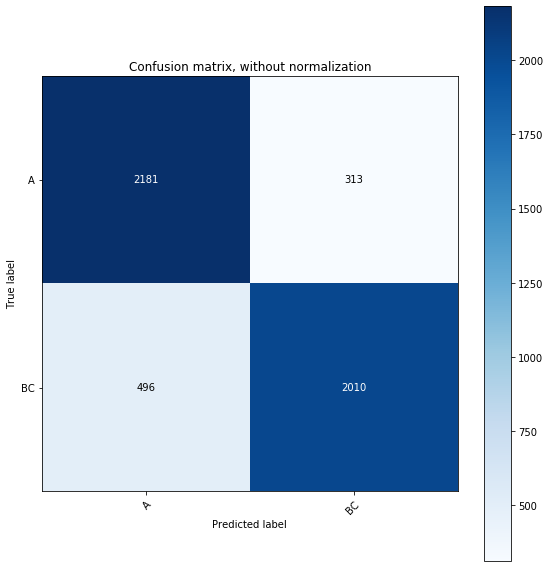

In [190]:
plot_confusion_matrix(y_valid.values, y_pred.astype(int), target_names)

# Best Score Acheivable via (kernel) SVM 

In [9]:
data = pd.DataFrame(X)
labels = pd.Series(y)
# data.hist(figsize=(20,12))

# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, labels, valid_size=0.5)

X_train = train_data
y_train = train_labels.copy()
y_train[y_train > 0] = 1

X_valid = test_data
y_valid = test_labels.copy()
y_valid[y_valid > 0] = 1

In [42]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", SVC(**{'C': 3a0, 'gamma': 'scale', 'kernel': 'rbf', "tol":0.001}))
])

clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVM',
                 SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [43]:
clf.score(X_valid,y_valid)

0.9336

In [18]:
%%time

kernel_params = [
    {
        "C":[.1,.5,1,10],
        "kernel":["rbf", "poly", "sigmoid"],
        "gamma":["scale", "auto"]
    }
]

kernel_grid = Pipeline([
    ("scaler", StandardScaler()),
    ("SVMGrid",GridSearchCV(SVC(), kernel_params, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=8))
])

kernel_grid.fit(X, y)
grid = kernel_grid.steps[1][1]
print(grid.best_params_)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
CPU times: user 1.6 s, sys: 184 ms, total: 1.79 s
Wall time: 1min 5s


In [23]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", SVC(**grid.best_params_))
])

svm_clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

_score = cross_val_score(svm_clf, X=X_train, y=y_train, cv=10)
print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

SVM Test Accuracy: 0.931
SVM CV Accuracy: 0.933(+/- 0.023)
